In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

In [2]:
full_train = pd.read_csv("train.csv", index_col="id")

y = full_train["Listening_Time_minutes"]
X = full_train.drop("Listening_Time_minutes", axis = 1)

In [3]:
full_train

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000


In [4]:
y.describe()

count    750000.000000
mean         45.437406
std          27.138306
min           0.000000
25%          23.178350
50%          43.379460
75%          64.811580
max         119.970000
Name: Listening_Time_minutes, dtype: float64

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [6]:
X_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
58797,Fitness First,Episode 8,67.60,Health,60.32,Monday,Night,NaN,1.0,Negative
350030,Humor Hub,Episode 68,34.00,Comedy,58.71,Tuesday,Morning,47.74,3.0,Negative
714763,Sports Weekly,Episode 92,45.15,Sports,29.48,Saturday,Evening,NaN,3.0,Positive
251121,True Crime Stories,Episode 24,83.70,True Crime,63.86,Saturday,Evening,NaN,3.0,Negative
428721,Lifestyle Lounge,Episode 4,99.32,Lifestyle,25.77,Friday,Morning,28.01,0.0,Neutral


Podcast_Name                      48
Episode_Title                    100
Episode_Length_minutes         12141
Genre                             10
Host_Popularity_percentage      8031
Publication_Day                    7
Publication_Time                   4
Guest_Popularity_percentage    10010
Number_of_Ads                     10
Episode_Sentiment                  3
dtype: int64


<AxesSubplot:title={'center':'Number of unique data values'}>

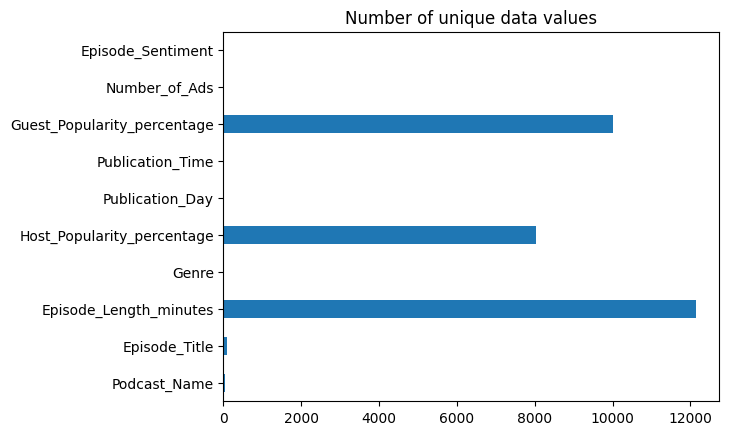

In [7]:
print(X_train.nunique())
X_train.nunique().plot(kind="barh", title = "Number of unique data values")

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          69676
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    116866
Number_of_Ads                       1
Episode_Sentiment                   0
dtype: int64


<AxesSubplot:title={'center':'Number of missing data values'}>

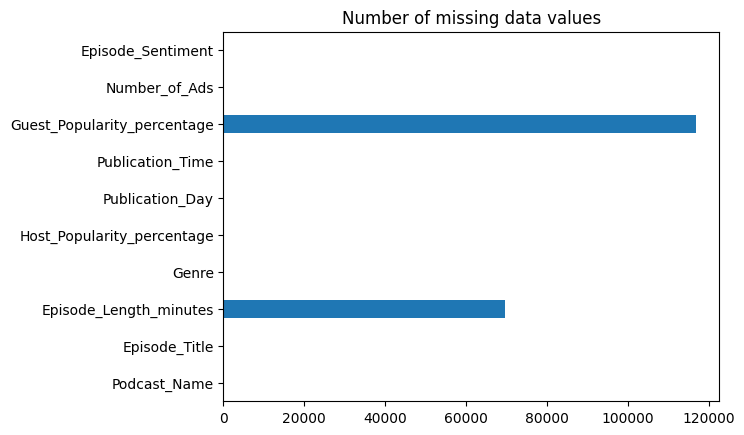

In [8]:
print(X_train.isnull().sum())
X_train.isnull().sum().plot(kind = "barh", title = "Number of missing data values")

In [23]:
# Getting numerical features
num_features = [col for col in X_train.columns if X_train[col].dtype == "float64"]
num_features

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads']

In [11]:
# Setting object types in training dataset to category types for xgboost
cat_features = [col for col in X_train.columns if X_train[col].dtype == "object"]
cat_features 
for cat_feat in cat_features:
    X_train[cat_feat] = X_train[cat_feat].astype("category")
    #print(X_train[cat_feat].dtype)


In [12]:
# Setting object types in validation dataset to category types for xgboost
cat_features = [col for col in X_val.columns if X_val[col].dtype == "object"]

for cat_feat in cat_features:    
    X_val[cat_feat] = X_val[cat_feat].astype("category")
#print(X_val.dtypes)

In [ ]:
# Label encoded the categorical features. Not using OH encdoding to reduce training time.

label_encoder = LabelEncoder()

for cat_feat in cat_features:
    X_train[cat_feat] = label_encoder.transform(X_train[cat_feat])
    X_val[cat_feat] = label_encoder.transform(X_val[cat_feat])

In [ ]:
# Creating Feature and Answer pairs for the correlation matrix
feat_label_pair = pd.concat([X_train,y_train], axis = 1)
feat_label_pair

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
58797,14,78,67.60,3,60.32,1,3,NaN,1.0,0,58.53161
350030,22,65,34.00,1,58.71,5,2,47.74,3.0,0,27.12000
714763,39,92,45.15,7,29.48,2,1,NaN,3.0,2,37.51460
251121,44,17,83.70,9,63.86,2,1,NaN,3.0,0,59.35737
428721,28,34,99.32,4,25.77,0,2,28.01,0.0,1,59.27804
...,...,...,...,...,...,...,...,...,...,...,...
359783,3,64,40.09,0,68.92,1,2,23.25,0.0,0,30.04023
152315,28,41,95.63,4,62.00,0,3,NaN,2.0,0,73.88733
117952,13,76,NaN,0,99.03,1,0,99.80,3.0,0,42.58376


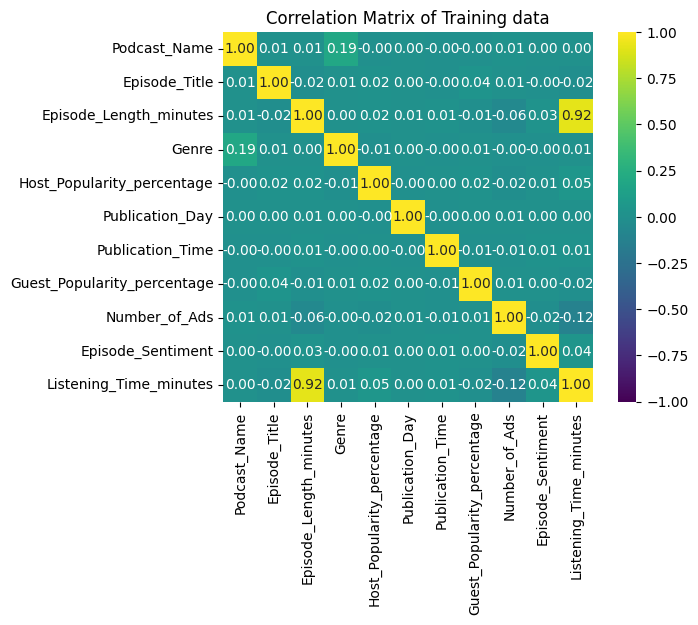

In [39]:
correlation_matrix = feat_label_pair.corr()
heatmap = sns.heatmap(correlation_matrix, 
                      annot = True,
                      vmin = -1,
                      vmax = 1,
                      center = 0,
                      cmap = "viridis",
                      fmt = ".2f",
                      square = True)
plt.title("Correlation Matrix of Training data")
plt.show()

In [44]:
num_imputer = SimpleImputer(strategy="mean")

X_train["Episode_Length_minutes"] = num_imputer.fit_transform(pd.DataFrame(X_train["Episode_Length_minutes"]))
X_val["Episode_Length_minutes"] = num_imputer.fit_transform(pd.DataFrame(X_val["Episode_Length_minutes"]))

In [45]:
X_train["Episode_Length_minutes"].isnull().sum()

0

In [46]:
model = XGBRegressor(enable_categorical = True)
model.fit(X_train, y_train)
preds = model.predict(X_val)

RMSE =  root_mean_squared_error(y_val, preds)
RMSE

13.127882377464248

In [ ]:
# first try, no cat or num imputing: 13.088236576209288
# with label encoding: 13.031150146367553
# With mean numeric imputing it gets worse: 13.127882377464248